In [1]:
%load_ext autoreload
%autoreload 2
import os, sys
sys.path.insert(1, '../')
import numpy as np
import pandas as pd
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, Polygon, MultiPolygon
from shapely.ops import cascaded_union
import alphashape
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from  matplotlib.colors import LinearSegmentedColormap
from ppi import clt_swr, binomial_iid, bentkus_iid, wsr_iid, wsr_swr, clt_iid
from scipy.special import expit
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import seaborn as sns
import mapclassify as mc
import warnings
import pdb

## Read and preprocess data

We read the data in from a `.csv` file with pre-computed predictions of forest cover and ground-truth labels.

In [2]:
# Read raw data
raw_df = pd.read_csv('./data.csv')

# Process raw data
df = raw_df[raw_df.Year1 != 'tdo'].copy()
df.Year1 = df.Year1.astype(float)

gt = (((df.Type1.astype(str) != 'nan') & ((df.Year1 >= 2000) & (df.Year1 <= 2015))) |
      ((df.Type2.astype(str) != 'nan') & ((df.Year2 >= 2000) & (df.Year2 <= 2015))) |
      ((df.Type3.astype(str) != 'nan') & ((df.Year3 >= 2000) & (df.Year3 <= 2015))) ).astype(float).to_numpy()

X = np.stack([
        df.tree_canopy_cover_2015/100,
        df.tree_canopy_cover_2000/100
    ], axis=1)

X_train, X, gt_train, gt = train_test_split(X,gt,test_size=0.5)

## Train the gradient boosting classifier

The ground truth labels are binary per-parcel labels indicating deforestation. The predictions are of forest cover in the years 2000 and 2015.  We train a gradient boosting classifier to learn a rule from the forest cover predictions to the binary labels.

In [3]:
cls = HistGradientBoostingClassifier(max_iter=100,max_depth=2).fit(
    X_train,
    gt_train
)

pred = cls.predict_proba(X)[:,1]

## Deforestation map

Plot the model predictions of deforestation as a Voronoi diagram.

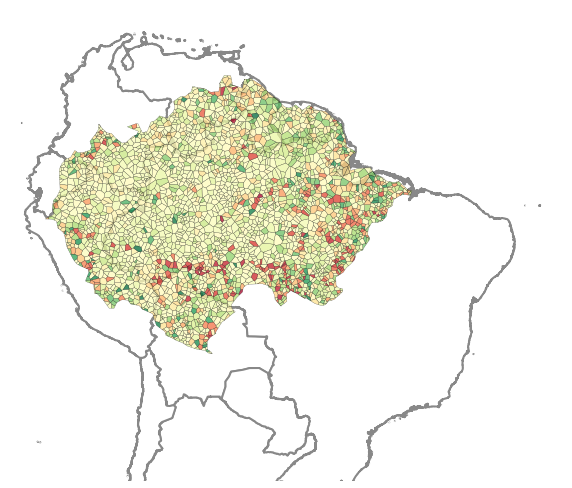

In [4]:
with warnings.catch_warnings(): # Ignore shapely deprecation warnings.
    warnings.simplefilter("ignore")
    # Colormap
    c = ["darkred","red","lightcoral","white", "palegreen","green","darkgreen"]
    v = [0,.15,.4,.6,0.7,.9,1.]
    l = list(zip(v,c))
    cmap=LinearSegmentedColormap.from_list('gr',l, N=256)

    world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

    gdf = gpd.GeoDataFrame(
        df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude)
    )

    sa = gpd.read_file("./shapefiles/s-america.shp").reset_index()[["geometry"]] # Read shapefile of S. America

    gdf["forest cover lost (%)"] = np.nan_to_num(gdf["tree_canopy_cover_2015"] - gdf["tree_canopy_cover_2000"])/100

    gdf_small = gdf.reset_index() #gdf.sample(n=500).reset_index() # To make it run faster, use this line
    alpha_shape = alphashape.alphashape(gdf_small)
    clipGDF = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry=[alpha_shape])

    base = sa.plot(color='#FFFFFF', edgecolor='#888888', linewidth=2, figsize=(10,10));

    scheme = mc.NaturalBreaks(gdf_small["forest cover lost (%)"], k=50)

    vor = gplt.voronoi(
        gdf_small, 
        projection=None,
        hue='forest cover lost (%)',
        scheme=scheme, 
        cmap='RdYlGn',
        legend=False,
        ax=base,
        alpha=0.75,
        linewidth=0.25,
        clip = clipGDF,
    )

    plt.xlim(-83,-30)
    plt.ylim(-30,15)
    plt.savefig('./map.png', dpi=500, bbox_inches='tight')

## Construct confidence intervals

Here are the confidence interval constructions. We use the sampling without replacement (a.k.a. finite population) version of the concentration inequalities. We use a standard binomial interval for the imputation strategy.

In [5]:
def ppi(l_gt,l_pred,thetaf,N,alpha):
    grid = np.linspace(0.45,0.55,1000)
    R = wsr_swr((l_gt-l_pred+1)/2, N, alpha, grid, intersection=False)*2 - 1
    #R = clt_swr((l_gt-l_pred+1)/2, N, alpha)*2 - 1
    C = R + thetaf
    return C

def classical(l_gt, N, alpha):
    grid = np.linspace(0.05,0.25,1000)
    return wsr_swr(l_gt, N, alpha, grid, intersection=False)
    #return clt_swr(l_gt, N, alpha)

def imputed(l_pred, N, alpha):
    return binomial_iid(N, alpha, (l_pred > 0.5).mean())
    #return clt_iid(l_pred, alpha)

In [6]:
print(gt.mean())
#print(ppi(gt,pred,pred.mean(),N,alpha))

0.16290726817042606


## Main experiment

Over 100 random subsamplings of the data and different values of n, compute the intervals and their lengths.

In [7]:
# Problem setup
ns = np.array([50,100,200,300,500,750,1000])
N = gt.shape[0]
num_trials = 100
alpha = 0.1
true_mean = gt.mean()
thetaf = pred.mean()
C_imputed = imputed(pred, N, alpha)


# Monte Carlo 
lengths = np.zeros((ns.shape[0],num_trials,2))
lower_endpoints = np.zeros((ns.shape[0],num_trials,2))
upper_endpoints = np.zeros((ns.shape[0],num_trials,2))
covereds = np.zeros((ns.shape[0],num_trials,2))
#with np.errstate(divide='ignore', invalid='ignore'):
for j in tqdm(range(ns.shape[0])):
    for i in range(num_trials):
        n = ns[j]
        labeled = np.random.permutation(N)[:n]
        l_pred, l_gt = pred[labeled], gt[labeled]

        # Run Prediction-Powered Inference
        C = ppi(l_gt, l_pred, thetaf, N, alpha)
        lengths[j,i,0] = C[1]-C[0]
        covereds[j,i,0] = (true_mean >= C[0]) & (true_mean <= C[1])
        lower_endpoints[j,i,0] = C[0]
        upper_endpoints[j,i,0] = C[1]


        # Run Classical
        C_classical = classical(l_gt, N, alpha)
        lengths[j,i,1] = C_classical[1] - C_classical[0]
        covereds[j,i,1] = (true_mean >= C_classical[0]) & (true_mean <= C_classical[1])
        lower_endpoints[j,i,1] = C_classical[0]
        upper_endpoints[j,i,1] = C_classical[1]

 57%|█████████████████████████▋                   | 4/7 [00:52<00:40, 13.35s/it]/Users/angelopoulos/Code/working/prediction-powered-inference/forest/../ppi.py:231: RuntimeWarning: divide by zero encountered in divide
  np.prod(1+np.minimum(lambdas[:i], 0.5/mu(m,i))*(x[:i]-mu(m,i))),
100%|█████████████████████████████████████████████| 7/7 [01:42<00:00, 14.60s/it]


## Report results

Below are two plots: one of the intervals themselves (the average lower and upper endpoint, because otherwise they are too random), and one of the widths.

In [8]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

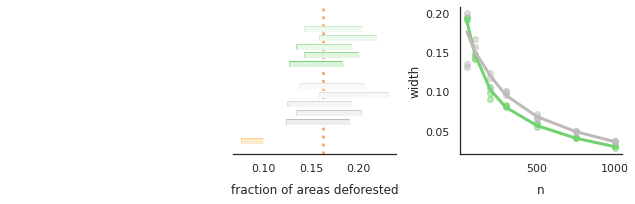

In [11]:
# Make plot
n_idx = 4
num_intervals = 5
linewidth = 5
linewidth_modifier = 1.1
offset = 0.25

pp_intervals = []
classical_intervals = []
for i in range(num_intervals):
    trial_idx = np.random.choice(num_trials)
    
    pp_intervals += [
        [lower_endpoints[n_idx,trial_idx,0], upper_endpoints[n_idx,trial_idx,0]]
    ]
    
    classical_intervals += [
        [lower_endpoints[n_idx,trial_idx,1], upper_endpoints[n_idx,trial_idx,1]]
    ]

xlim = [None, None]
ylim = [0,1.15]
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(9,3))
sns.set_theme(style="white", font_scale=1, font="DejaVu Sans")

axs[1].axvline(true_mean, ymin=0.0, ymax=1, linestyle="dotted", linewidth=3, label="true deforestation fraction", color="#F7AE7C")

for i in reversed(range(num_intervals)):
    pp_interval = pp_intervals[i]
    classical_interval = classical_intervals[i]
    
    if i == 0:
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7, 0.7], linewidth=linewidth, color="#DAF3DA", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#71D26F"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#71D26F"), pe.Normal()], label=' prediction-powered', solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25,0.25], linewidth=linewidth, color="#EEEDED", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#BFB9B9"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#BFB9B9"), pe.Normal()], label=' classical', solid_capstyle="butt")
        axs[1].plot([C_imputed[0], C_imputed[1]],[0.1, 0.1], linewidth=linewidth, color="#FFEACC", path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground="#FFCD82"), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground="#FFCD82"), pe.Normal()], label=' imputed', solid_capstyle="butt")
    else:
        lighten_factor = 0.8/np.sqrt(i)
        yshift = i*0.07
        axs[1].plot([pp_interval[0], pp_interval[1]],[0.7 + yshift, 0.7 + yshift], linewidth=linewidth, color=lighten_color("#DAF3DA", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#71D26F", lighten_factor)), pe.Normal()], solid_capstyle="butt")
        axs[1].plot([classical_interval[0], classical_interval[1]],[0.25 + yshift,0.25 + yshift], linewidth=linewidth, color=lighten_color("#EEEDED", lighten_factor), path_effects=[pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(-offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Stroke(linewidth=linewidth * linewidth_modifier, offset=(offset,0), foreground=lighten_color("#BFB9B9", lighten_factor)), pe.Normal()], solid_capstyle="butt")


axs[1].set_xlabel("fraction of areas deforested", labelpad=10)
axs[1].set_yticks([])
axs[1].set_yticklabels([])
axs[1].set_ylim(ylim)
axs[1].set_xlim(xlim)

sns.despine(ax=axs[1],top=True,right=True,left=True)

axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,0]-lower_endpoints.mean(axis=1)[:,0], label="prediction-powered", color="#71D26F", linewidth=3)
num_scatter = 3
rand_idx_scatter = [np.random.choice(num_trials, size=num_scatter).astype(int) for n in ns]

scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,0][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,0][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#71D26F",
    alpha=0.5
)
    
axs[2].plot(ns, upper_endpoints.mean(axis=1)[:,1]-lower_endpoints.mean(axis=1)[:,1], label="classical", color="#BFB9B9", linewidth=3)
scatter_xs = np.concatenate([np.concatenate([[ns[j]] * num_trials])[rand_idx_scatter[j]] for j in range(ns.shape[0])])
scatter_ys = np.concatenate([upper_endpoints[j,:,1][rand_idx_scatter[j]].flatten() - lower_endpoints[j,:,1][rand_idx_scatter[j]].flatten() for j in range(ns.shape[0])])
axs[2].scatter(
    scatter_xs,
    scatter_ys,
    color="#BFB9B9",
    alpha=0.5
)

axs[2].locator_params(axis='y', tight=None, nbins=6)
axs[2].set_ylabel("width")
axs[2].set_xlabel("n",  labelpad=10)
sns.despine(ax=axs[2],top=True, right=True)

sns.despine(ax=axs[0],top=True, right=True, left=True, bottom=True)
axs[0].set_xticklabels([])
axs[0].set_yticklabels([])
axs[0].set_xticks([])
axs[0].set_yticks([])

plt.tight_layout()
plt.savefig('./allplots.pdf')

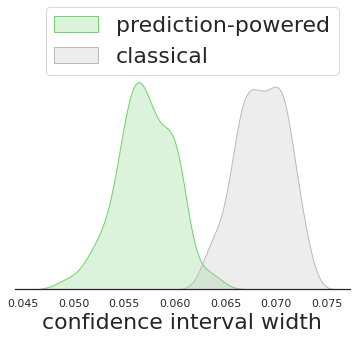

In [10]:
# Width kdeplot
estimator = np.array(num_trials*['prediction-powered'] + num_trials*['classical'])
width = np.concatenate([lengths[n_idx,:,0],lengths[n_idx,:,1]]) # n = 100
kde_df = pd.DataFrame(np.stack([estimator,width],axis=1), columns=["estimator", "width"])
kde_df["width"] = kde_df["width"].astype(float)

# Make plot
my_palette = sns.color_palette(["#BFB9B9","#71D26F"], 2)
plt.figure()
sns.set_theme(style="white", palette=my_palette, font="DejaVu Sans")
kde = sns.kdeplot(kde_df, x="width", hue="estimator", hue_order=[ "classical","prediction-powered"], fill=True, clip=(0,None))
plt.gca().set_ylabel("")
plt.gca().set_xlabel("confidence interval width", fontsize=22)
plt.gca().set_yticks([])
plt.gca().set_yticklabels([])
sns.despine(ax=plt.gca(),top=True,right=True,left=True)
kde.get_legend().remove()
plt.gca().legend(["prediction-powered", "classical"], fontsize=22, bbox_to_anchor=(1,1.35))
plt.savefig('./widths.pdf', bbox_inches='tight')